In [2]:
pip install nba_api

Note: you may need to restart the kernel to use updated packages.


In [13]:
from nba_api.stats.endpoints import shotchartdetail
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

In [14]:
#FUNCTION TO INPUT PLAYER NAME INTO JSON CALL

def player_name_input():
    while True:
        try:
            playername = input("Enter an NBA player's full name: ")
            #print(playername)
        except ValueError:
            print("Cannot find player! Try again!")
            continue
        playerlst = playername.split(' ')
        playerfirst = playerlst[0]
        playerlast = playername[len(playerfirst)+1:len(playername)]
        #return '("'+playerfirst+'", "'+playerlast+'")'
        from nba_api.stats.static import players
        nba_players = players.get_players()

        for player in nba_players:
            if player['full_name'].lower() == playerfirst.lower()+' '+playerlast.lower():
                #While statement to confirm input is correct
                return player['id']
                break
        else:
            print("Invalid player name- try again!")
            continue
                

#FUNCTION TO INPUT PREFERRED SEASON

#testing_playerid = player_name_input()

def season_input(playerid):
    """
    take player id input from user to validate season input from user.
    raise different exceptions for two issue types:
    1. date format is incorrect (must be YYYY-YY)
    2. player did not play during the season inputted (started career in 2019, user inputted 2016)
    """
    while True:
        try:
            season = input("Enter the season (2013-14 or later) in this format: YYYY-YY (2022-23, for example): ")
        except ValueError:
            print("Invalid input! Use YYYY-YY format and ensure year is 2013 or later")
            continue
        from nba_api.stats.endpoints import playercareerstats
        career = playercareerstats.PlayerCareerStats(player_id=playerid)
        player_career_data = career.get_data_frames()[0]
        mapping_team_table = player_career_data.iloc[:,0:4]
        mapping_team_table
        resultdf = mapping_team_table['SEASON_ID']
        pattern = r'\d{4}-\d{2}$'  
        if (len(re.findall(pattern, season)) == 1) and (int(season[0:4]) > 2012) and \
        (mapping_team_table['SEASON_ID'].str.contains(season).any()):
            #print(len(re.findall(pattern, season)))
            return season
            break
        elif (len(re.findall(pattern, season)) == 1) and (int(season[0:4]) > 2012) and \
                (mapping_team_table['SEASON_ID'].str.contains(season).any()==False):
            print("Invalid input! Player did not play this season. Please re-input")
            continue
        else:
            print("Invalid input! Use YYYY-YY format and ensure year is 2013 or later")
            continue


def team_id_retrieval(playerid, season):
    """
    Retrieve Team ID unsing inputs from 
    season_input and player_name_input functions
    """
    from nba_api.stats.endpoints import playercareerstats
    career = playercareerstats.PlayerCareerStats(player_id=playerid)
    player_career_data = career.get_data_frames()[0]
    mapping_team_table = player_career_data.iloc[:,0:4]
    mapping_team_table
    resultdf = mapping_team_table[mapping_team_table['SEASON_ID'] == season]
    return resultdf['TEAM_ID'].values[0]


def player_name_return(playerid):
    from nba_api.stats.static import players
    nba_players = players.get_players()
    
    for player in nba_players:
        if player['id'] == playerid:
            #While statement to confirm input is correct
            return player['full_name']
    return "Invalid Player Name"




In [15]:
player_id_input = player_name_input()
season_id_input = season_input(player_id_input)
team_id_input = team_id_retrieval(player_id_input, season_id_input)
player_name_for_display = player_name_return(player_id_input)
label_value = player_name_for_display +'\n'+ season_id_input+" Season"

shot_json = shotchartdetail.ShotChartDetail(
            team_id = team_id_input,
            player_id = player_id_input,
            context_measure_simple = 'PTS',
            season_nullable = season_id_input,
            season_type_all_star = 'Regular Season')


Enter an NBA player's full name: lebronkames
Invalid player name- try again!
Enter an NBA player's full name: lebron james
Enter the season (2013-14 or later) in this format: YYYY-YY (2022-23, for example): 2012-13
Invalid input! Use YYYY-YY format and ensure year is 2013 or later
Enter the season (2013-14 or later) in this format: YYYY-YY (2022-23, for example): 2013-2014
Invalid input! Use YYYY-YY format and ensure year is 2013 or later
Enter the season (2013-14 or later) in this format: YYYY-YY (2022-23, for example): 2016-17


In [16]:
shot_data = json.loads(shot_json.get_json())

In [17]:
relevant_data = shot_data['resultSets'][0]
headers = relevant_data['headers']
rows = relevant_data['rowSet']

# Create pandas DataFrame
shooter_data = pd.DataFrame(rows)
shooter_data.columns = headers

In [18]:
shooter_data.columns


Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [19]:
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

In [20]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2


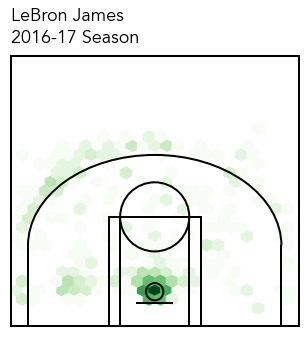

In [21]:
# Create figure and axes
fig = plt.figure(figsize=(4, 3.76))
ax = fig.add_axes([0, 0, 1, 1])



# Plot hexbin of shots
ax.hexbin(shooter_data['LOC_X'], shooter_data['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='Greens')

# Annotate player name and season using label value as cocnat for input
ax.text(0, 1.05, label_value, transform=ax.transAxes, ha='left', va='baseline')

# Draw court
ax = create_court(ax, 'black')

# Save and show figure
plt.savefig('ShotChart.png', dpi=300, bbox_inches='tight')


plt.show()